# ORF recognition by Convolutional/Recurrent

Test CNN+GRU 16 on simulated RNA of length 64. 

Use restructured codebase from notebook 105.

In [1]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-21 17:21:01 UTC'

In [2]:
PC_SEQUENCES=32000   # how many protein-coding sequences
NC_SEQUENCES=32000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
RNA_LEN=64            # how long is each sequence
CDS_LEN=32            # min CDS len to be coding
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (RNA_LEN,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (RNA_LEN,ALPHABET) # Conv1D needs 2D inputs
FILTERS = 16   # how many different patterns the model looks for
CELLS = 16
NEURONS = 16
DROP_RATE = 0.4
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases
EPOCHS=100  # how many times to train on all the data
SPLITS=3  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=3  # train the model this many times (range 1 to SPLITS)

In [3]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    from RNA_describe import Random_Base_Oracle
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import prepare_inputs_len_x_alphabet
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter,Random_Base_Oracle
        from SimTools.RNA_prep import prepare_inputs_len_x_alphabet

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login


On Google CoLab, mount cloud-local file, get our code from GitHub.


In [4]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Conv1D,Conv2D
from keras.layers import GRU,LSTM
from keras.layers import Flatten,TimeDistributed
from keras.layers import MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [5]:
rbo=Random_Base_Oracle(RNA_LEN,True)
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,10) # just testing
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,PC_SEQUENCES+PC_TESTS)
print("Use",len(pc_all),"PC seqs")
print("Use",len(nc_all),"NC seqs")

It took 56 trials to reach 10 per class.
It took 103391 trials to reach 33000 per class.
Use 33000 PC seqs
Use 33000 NC seqs


In [6]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("Simulated sequences prior to adjustment:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)

Simulated sequences prior to adjustment:
PC seqs
Average RNA length: 64.0
Average ORF length: 38.32090909090909
NC seqs
Average RNA length: 64.0
Average ORF length: 8.165


In [7]:
pc_train=pc_all[:PC_SEQUENCES]
nc_train=nc_all[:NC_SEQUENCES]
pc_test=pc_all[PC_SEQUENCES:]
nc_test=nc_all[NC_SEQUENCES:]

In [8]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [9]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=INPUT_SHAPE,output_dim=INPUT_SHAPE)) 
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same",
            input_shape=INPUT_SHAPE))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(MaxPooling1D())
    #dnn.add(TimeDistributed(Flatten()))
    dnn.add(GRU(CELLS,return_sequences=True))
    dnn.add(GRU(CELLS,return_sequences=False))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE)
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (64, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 64, 16)            208       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 16)            784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 16)            0         
_________________________________________________________________
gru (GRU)                    (None, 32, 16)            1632      
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                1632      
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dropout (Dropout)         

In [10]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (64, 4)
FIT
Epoch 1/100
1334/1334 [==============================] - 41s 8ms/step - loss: 0.7022 - accuracy: 0.5273 - val_loss: 0.6451 - val_accuracy: 0.6192


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 2/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.6357 - accuracy: 0.6342 - val_loss: 0.6229 - val_accuracy: 0.6397


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 3/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.6281 - accuracy: 0.6419 - val_loss: 0.6246 - val_accuracy: 0.6440


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 4/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.6212 - accuracy: 0.6492 - val_loss: 0.6102 - val_accuracy: 0.6576


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 5/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.6002 - accuracy: 0.6677 - val_loss: 0.5693 - val_accuracy: 0.6911


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 6/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5663 - accuracy: 0.6933 - val_loss: 0.5597 - val_accuracy: 0.6942


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 7/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5602 - accuracy: 0.6968 - val_loss: 0.5479 - val_accuracy: 0.7016


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 8/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5509 - accuracy: 0.7018 - val_loss: 0.5471 - val_accuracy: 0.6978
Epoch 9/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5457 - accuracy: 0.7020 - val_loss: 0.5430 - val_accuracy: 0.6992
Epoch 10/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5369 - accuracy: 0.7123 - val_loss: 0.5426 - val_accuracy: 0.7017


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 11/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5425 - accuracy: 0.7054 - val_loss: 0.5356 - val_accuracy: 0.7056


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 12/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5339 - accuracy: 0.7102 - val_loss: 0.5401 - val_accuracy: 0.7040
Epoch 13/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5372 - accuracy: 0.7070 - val_loss: 0.5422 - val_accuracy: 0.6996
Epoch 14/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5371 - accuracy: 0.7074 - val_loss: 0.5397 - val_accuracy: 0.7035
Epoch 15/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5328 - accuracy: 0.7111 - val_loss: 0.5344 - val_accuracy: 0.7071


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 16/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5305 - accuracy: 0.7108 - val_loss: 0.5345 - val_accuracy: 0.7115


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 17/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5319 - accuracy: 0.7088 - val_loss: 0.5342 - val_accuracy: 0.7082
Epoch 18/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5259 - accuracy: 0.7171 - val_loss: 0.5280 - val_accuracy: 0.7092
Epoch 19/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5257 - accuracy: 0.7138 - val_loss: 0.5321 - val_accuracy: 0.7073
Epoch 20/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5245 - accuracy: 0.7135 - val_loss: 0.5415 - val_accuracy: 0.7066
Epoch 21/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5261 - accuracy: 0.7147 - val_loss: 0.5529 - val_accuracy: 0.7003
Epoch 22/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5227 - accuracy: 0.7146 - val_loss: 0.5302 - val_accuracy: 0.7106
Epoch 23/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5188 - accuracy: 0.7182 - val_loss: 0.5545 -

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 26/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5199 - accuracy: 0.7141 - val_loss: 0.5272 - val_accuracy: 0.7166


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 27/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5184 - accuracy: 0.7204 - val_loss: 0.5306 - val_accuracy: 0.7141
Epoch 28/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5174 - accuracy: 0.7170 - val_loss: 0.5254 - val_accuracy: 0.7182


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 29/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5190 - accuracy: 0.7157 - val_loss: 0.5247 - val_accuracy: 0.7169
Epoch 30/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5156 - accuracy: 0.7192 - val_loss: 0.5232 - val_accuracy: 0.7169
Epoch 31/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5167 - accuracy: 0.7179 - val_loss: 0.5237 - val_accuracy: 0.7194


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 32/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5124 - accuracy: 0.7180 - val_loss: 0.5213 - val_accuracy: 0.7190
Epoch 33/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5138 - accuracy: 0.7192 - val_loss: 0.5219 - val_accuracy: 0.7173
Epoch 34/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5141 - accuracy: 0.7182 - val_loss: 0.5220 - val_accuracy: 0.7219


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 35/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5136 - accuracy: 0.7204 - val_loss: 0.5178 - val_accuracy: 0.7226


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 36/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5090 - accuracy: 0.7268 - val_loss: 0.5210 - val_accuracy: 0.7176
Epoch 37/100
1334/1334 [==============================] - 10s 7ms/step - loss: 0.5115 - accuracy: 0.7206 - val_loss: 0.5218 - val_accuracy: 0.7171
Epoch 38/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5060 - accuracy: 0.7267 - val_loss: 0.5193 - val_accuracy: 0.7206
Epoch 39/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5098 - accuracy: 0.7199 - val_loss: 0.5175 - val_accuracy: 0.7210
Epoch 40/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5071 - accuracy: 0.7251 - val_loss: 0.5272 - val_accuracy: 0.7219
Epoch 41/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5047 - accuracy: 0.7261 - val_loss: 0.5198 - val_accuracy: 0.7183
Epoch 42/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5073 - accuracy: 0.7247 - val_loss: 0.5210 

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 44/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5026 - accuracy: 0.7279 - val_loss: 0.5318 - val_accuracy: 0.7155
Epoch 45/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5020 - accuracy: 0.7275 - val_loss: 0.5204 - val_accuracy: 0.7222
Epoch 46/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5026 - accuracy: 0.7318 - val_loss: 0.5301 - val_accuracy: 0.7150
Epoch 47/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5024 - accuracy: 0.7273 - val_loss: 0.5230 - val_accuracy: 0.7182
Epoch 48/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5002 - accuracy: 0.7274 - val_loss: 0.5133 - val_accuracy: 0.7232
Epoch 49/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4953 - accuracy: 0.7312 - val_loss: 0.5214 - val_accuracy: 0.7212
Epoch 50/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4978 - accuracy: 0.7300 - val_loss: 0.5140 -

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 51/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4935 - accuracy: 0.7329 - val_loss: 0.5162 - val_accuracy: 0.7253
Epoch 52/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4979 - accuracy: 0.7294 - val_loss: 0.5168 - val_accuracy: 0.7242
Epoch 53/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4915 - accuracy: 0.7367 - val_loss: 0.5116 - val_accuracy: 0.7240
Epoch 54/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4918 - accuracy: 0.7322 - val_loss: 0.5109 - val_accuracy: 0.7262


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 55/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4886 - accuracy: 0.7370 - val_loss: 0.5146 - val_accuracy: 0.7246
Epoch 56/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4890 - accuracy: 0.7382 - val_loss: 0.5105 - val_accuracy: 0.7262
Epoch 57/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4902 - accuracy: 0.7378 - val_loss: 0.5189 - val_accuracy: 0.7226
Epoch 58/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4902 - accuracy: 0.7364 - val_loss: 0.5131 - val_accuracy: 0.7253
Epoch 59/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4914 - accuracy: 0.7327 - val_loss: 0.5092 - val_accuracy: 0.7309


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 60/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4816 - accuracy: 0.7405 - val_loss: 0.5033 - val_accuracy: 0.7312


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 61/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4849 - accuracy: 0.7389 - val_loss: 0.5288 - val_accuracy: 0.7143
Epoch 62/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4819 - accuracy: 0.7413 - val_loss: 0.5033 - val_accuracy: 0.7323


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 63/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4760 - accuracy: 0.7473 - val_loss: 0.5035 - val_accuracy: 0.7360


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 64/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4822 - accuracy: 0.7445 - val_loss: 0.5069 - val_accuracy: 0.7331
Epoch 65/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4763 - accuracy: 0.7472 - val_loss: 0.4957 - val_accuracy: 0.7390


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 66/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4754 - accuracy: 0.7474 - val_loss: 0.4972 - val_accuracy: 0.7374
Epoch 67/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4764 - accuracy: 0.7491 - val_loss: 0.4958 - val_accuracy: 0.7392


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 68/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4739 - accuracy: 0.7488 - val_loss: 0.4982 - val_accuracy: 0.7393


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 69/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4744 - accuracy: 0.7532 - val_loss: 0.4917 - val_accuracy: 0.7418


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 70/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4740 - accuracy: 0.7503 - val_loss: 0.4929 - val_accuracy: 0.7414
Epoch 71/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4740 - accuracy: 0.7493 - val_loss: 0.4944 - val_accuracy: 0.7427


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 72/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4769 - accuracy: 0.7485 - val_loss: 0.4944 - val_accuracy: 0.7426
Epoch 73/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4692 - accuracy: 0.7523 - val_loss: 0.4897 - val_accuracy: 0.7475


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 74/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4625 - accuracy: 0.7541 - val_loss: 0.4995 - val_accuracy: 0.7449
Epoch 75/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4635 - accuracy: 0.7577 - val_loss: 0.4868 - val_accuracy: 0.7465
Epoch 76/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4620 - accuracy: 0.7587 - val_loss: 0.4748 - val_accuracy: 0.7549


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 77/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4583 - accuracy: 0.7655 - val_loss: 0.4799 - val_accuracy: 0.7485
Epoch 78/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4523 - accuracy: 0.7700 - val_loss: 0.4725 - val_accuracy: 0.7564


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 79/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4512 - accuracy: 0.7711 - val_loss: 0.4721 - val_accuracy: 0.7588


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 80/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4498 - accuracy: 0.7717 - val_loss: 0.4729 - val_accuracy: 0.7589


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 81/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4565 - accuracy: 0.7684 - val_loss: 0.4626 - val_accuracy: 0.7639


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 82/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4433 - accuracy: 0.7740 - val_loss: 0.4682 - val_accuracy: 0.7668


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 83/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4424 - accuracy: 0.7805 - val_loss: 0.4611 - val_accuracy: 0.7666
Epoch 84/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4423 - accuracy: 0.7742 - val_loss: 0.4557 - val_accuracy: 0.7722


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 85/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4406 - accuracy: 0.7777 - val_loss: 0.4485 - val_accuracy: 0.7757


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 86/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4350 - accuracy: 0.7792 - val_loss: 0.4493 - val_accuracy: 0.7765


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 87/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4610 - accuracy: 0.7692 - val_loss: 0.4761 - val_accuracy: 0.7592
Epoch 88/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4543 - accuracy: 0.7711 - val_loss: 0.4479 - val_accuracy: 0.7785


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 89/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4333 - accuracy: 0.7851 - val_loss: 0.4299 - val_accuracy: 0.7886


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 90/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4163 - accuracy: 0.7988 - val_loss: 0.4201 - val_accuracy: 0.7946


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 91/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4063 - accuracy: 0.8028 - val_loss: 0.4128 - val_accuracy: 0.7995


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 92/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.3868 - accuracy: 0.8170 - val_loss: 0.3965 - val_accuracy: 0.8061


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 93/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.3904 - accuracy: 0.8125 - val_loss: 0.3958 - val_accuracy: 0.8098


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 94/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.3832 - accuracy: 0.8178 - val_loss: 0.3728 - val_accuracy: 0.8165


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 95/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.3748 - accuracy: 0.8196 - val_loss: 0.3664 - val_accuracy: 0.8174


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 96/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5701 - accuracy: 0.6934 - val_loss: 0.6329 - val_accuracy: 0.6223
Epoch 97/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.6387 - accuracy: 0.6243 - val_loss: 0.6194 - val_accuracy: 0.6323
Epoch 98/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.6244 - accuracy: 0.6438 - val_loss: 0.5961 - val_accuracy: 0.6598
Epoch 99/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5933 - accuracy: 0.6673 - val_loss: 0.5729 - val_accuracy: 0.6778
Epoch 100/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5693 - accuracy: 0.6885 - val_loss: 0.5653 - val_accuracy: 0.6927
Fold 1, 100 epochs, 1258 sec


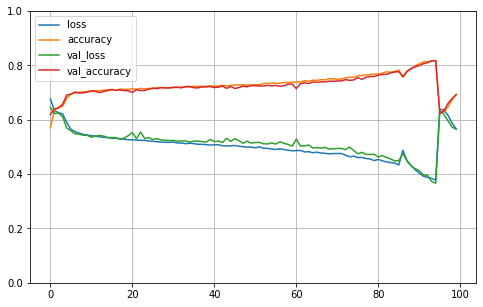

MODEL
make_DNN
input shape: (64, 4)
FIT
Epoch 1/100
1334/1334 [==============================] - 13s 8ms/step - loss: 0.7138 - accuracy: 0.5175 - val_loss: 0.6356 - val_accuracy: 0.6359
Epoch 2/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.6396 - accuracy: 0.6305 - val_loss: 0.6224 - val_accuracy: 0.6459
Epoch 3/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.6291 - accuracy: 0.6407 - val_loss: 0.6177 - val_accuracy: 0.6495
Epoch 4/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.6238 - accuracy: 0.6445 - val_loss: 0.6204 - val_accuracy: 0.6493
Epoch 5/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.6191 - accuracy: 0.6468 - val_loss: 0.6128 - val_accuracy: 0.6541
Epoch 6/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.6166 - accuracy: 0.6561 - val_loss: 0.6042 - val_accuracy: 0.6663
Epoch 7/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.6032 - acc

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 36/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4598 - accuracy: 0.7649 - val_loss: 0.4574 - val_accuracy: 0.7751
Epoch 37/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4437 - accuracy: 0.7836 - val_loss: 0.4145 - val_accuracy: 0.8059
Epoch 38/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4630 - accuracy: 0.7703 - val_loss: 0.4301 - val_accuracy: 0.7916
Epoch 39/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4411 - accuracy: 0.7825 - val_loss: 0.4372 - val_accuracy: 0.7875
Epoch 40/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4478 - accuracy: 0.7739 - val_loss: 0.4342 - val_accuracy: 0.7899
Epoch 41/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4473 - accuracy: 0.7760 - val_loss: 0.4342 - val_accuracy: 0.7879
Epoch 42/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4492 - accuracy: 0.7746 - val_loss: 0.4223 -

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 73/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.3233 - accuracy: 0.8400 - val_loss: 0.3027 - val_accuracy: 0.8517


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 74/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.3400 - accuracy: 0.8296 - val_loss: 0.4102 - val_accuracy: 0.8138
Epoch 75/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4424 - accuracy: 0.7895 - val_loss: 0.3952 - val_accuracy: 0.8018
Epoch 76/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.3751 - accuracy: 0.8137 - val_loss: 0.4704 - val_accuracy: 0.7562
Epoch 77/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4406 - accuracy: 0.7806 - val_loss: 0.4103 - val_accuracy: 0.7937
Epoch 78/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4030 - accuracy: 0.8027 - val_loss: 0.3884 - val_accuracy: 0.8054
Epoch 79/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.3728 - accuracy: 0.8161 - val_loss: 0.3121 - val_accuracy: 0.8462
Epoch 80/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.3312 - accuracy: 0.8385 - val_loss: 0.3126 -

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 89/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.3188 - accuracy: 0.8453 - val_loss: 0.3522 - val_accuracy: 0.8326
Epoch 90/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.3370 - accuracy: 0.8395 - val_loss: 0.3129 - val_accuracy: 0.8497
Epoch 91/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.3334 - accuracy: 0.8388 - val_loss: 0.3080 - val_accuracy: 0.8497
Epoch 92/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.3048 - accuracy: 0.8497 - val_loss: 0.2952 - val_accuracy: 0.8552
Epoch 93/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.3371 - accuracy: 0.8251 - val_loss: 0.6855 - val_accuracy: 0.5589
Epoch 94/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.6303 - accuracy: 0.6297 - val_loss: 0.3354 - val_accuracy: 0.8373
Epoch 95/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.3466 - accuracy: 0.8370 - val_loss: 0.4445 -

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 98/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.3072 - accuracy: 0.8499 - val_loss: 0.3073 - val_accuracy: 0.8504
Epoch 99/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.2904 - accuracy: 0.8565 - val_loss: 0.3351 - val_accuracy: 0.8402
Epoch 100/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.2878 - accuracy: 0.8622 - val_loss: 0.2813 - val_accuracy: 0.8635


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Fold 2, 100 epochs, 962 sec


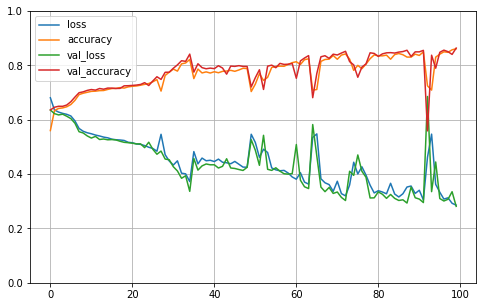

MODEL
make_DNN
input shape: (64, 4)
FIT
Epoch 1/100
1334/1334 [==============================] - 13s 7ms/step - loss: 0.7032 - accuracy: 0.5332 - val_loss: 0.6446 - val_accuracy: 0.6237
Epoch 2/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.6377 - accuracy: 0.6318 - val_loss: 0.6261 - val_accuracy: 0.6367
Epoch 3/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.6286 - accuracy: 0.6381 - val_loss: 0.6232 - val_accuracy: 0.6401
Epoch 4/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.6226 - accuracy: 0.6458 - val_loss: 0.6207 - val_accuracy: 0.6411
Epoch 5/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.6227 - accuracy: 0.6462 - val_loss: 0.6196 - val_accuracy: 0.6421
Epoch 6/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.6191 - accuracy: 0.6515 - val_loss: 0.6173 - val_accuracy: 0.6458
Epoch 7/100
1334/1334 [==============================] - 9s 7ms/step - loss: 0.6172 - acc

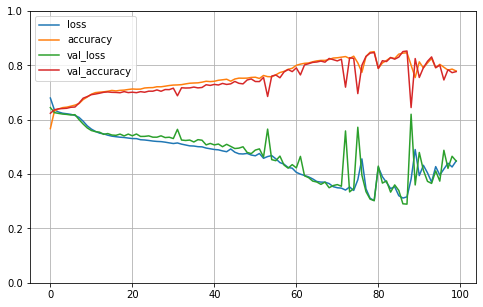

In [11]:
do_cross_validation(X,y)

In [12]:
from keras.models import load_model
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 85.80%


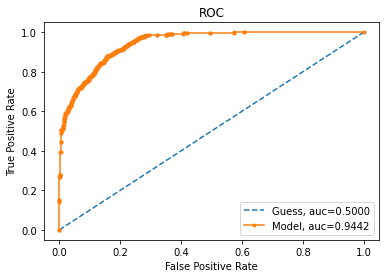

AUC: 94.42%


In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))


In [14]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-21 18:14:02 UTC'